In [1]:
from acevedo_clss_and_fcns import * 
device = 'cpu'
if torch.cuda.is_available():
    torch.cuda.init()
    if torch.cuda.is_initialized():
        device = 'cuda:0'
print(f"{device = }")
from torch_geometric.nn import GNNExplainer

import pickle

with open('./results/training_validation_best_models_paths/training_results.pickle', 'rb') as file:
    training_results = pickle.load(file)  
    

n_patients = 500
    
def get_explanations(model, loader):
    
    explainer    = GNNExplainer(model, epochs=500, num_hops = None, lr=0.01).to(device, non_blocking=True)
    model.to(device, non_blocking=True)


    model.eval()
    gc.collect()
    torch.cuda.empty_cache() 
    edge_num           = loader.dataset[0].edge_index.shape[1]
    all_graphs_weights = []#torch.empty(edge_num,1).to(device)

    for graph in loader.dataset[0:n_patients]:
        _, edge_weights =  explainer.explain_graph(graph.x.to(device, non_blocking=True), graph.edge_index.to(device, non_blocking=True))
        
        all_graphs_weights.append(edge_weights.reshape(edge_num,1))
        
        
        

    return pd.DataFrame(
                        torch.stack(all_graphs_weights,1).squeeze().cpu().numpy().astype(float))
    

/DeepenData/.miniconda/envs/geo/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device = 'cuda:0'


In [2]:
GIN_masked_flux = torch.load(training_results['GIN_masked_flux'][0])
GIN_masked_concen = torch.load(training_results['GIN_masked_concen'][0])
GIN_masked_concen_plus_flux = torch.load(training_results['GIN_masked_concen_plus_flux'][0])

In [3]:
%%time

MASKED_loader_only_Concen               = torch.load("./results/dataloaders/MASKED_loader_only_Concen.pt").get_test_loader()
Explanations_MASKED_GCN_Concentration   = get_explanations(GIN_masked_concen, MASKED_loader_only_Concen)

MASKED_loader_only_Fluxes               = torch.load("./results/dataloaders/MASKED_loader_only_Fluxes.pt").get_test_loader()
Explanations_MASKED_GCN_Fluxes          = get_explanations(GIN_masked_flux, MASKED_loader_only_Fluxes)


MASKED_loader_Concen_plus_Fluxes             = torch.load("./results/dataloaders/MASKED_loader_Concen_plus_Fluxes.pt").get_test_loader()
Explanations_MASKED_GCN_Concen_plus_Fluxes   = get_explanations(GIN_masked_concen_plus_flux, MASKED_loader_Concen_plus_Fluxes)    

Explain graph: 100%|██████████| 500/500 [00:00<00:00, 508.27it/s]


CPU times: user 23min 54s, sys: 12.6 s, total: 24min 7s
Wall time: 23min 59s


array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>],
      dtype=object)

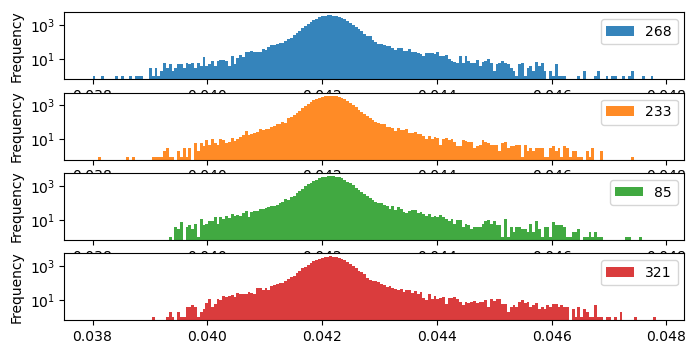

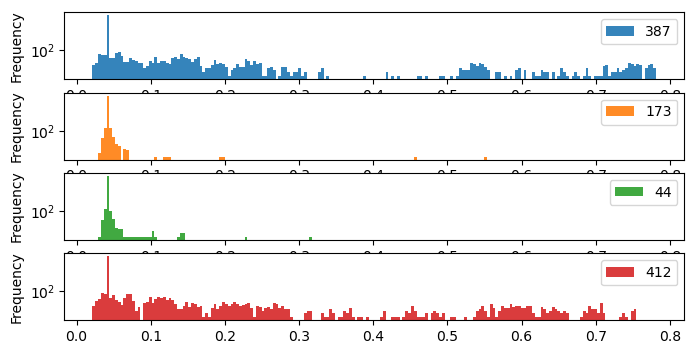

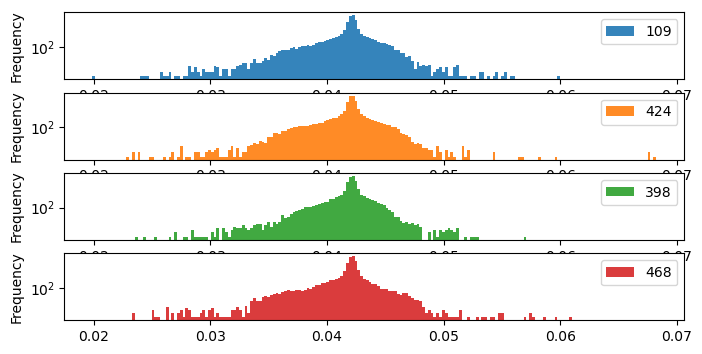

In [4]:
def plot_explanation_sample(explanations):
    return explanations.loc[:,np.random.randint(0, explanations.columns.__len__(), 4 )].select_dtypes(float).plot.hist(bins=200, alpha=0.9, figsize=(8,4), subplots=True, sharey=False, 
                      sharex=False, logy = True, grid=False)


plot_explanation_sample(Explanations_MASKED_GCN_Fluxes)
plot_explanation_sample(Explanations_MASKED_GCN_Concentration)
plot_explanation_sample(Explanations_MASKED_GCN_Concen_plus_Fluxes)

In [5]:
def get_df_labels_and_colnames(all_graphs_weights_df, loader, path_to_save_labels, path_PYG_graph, path_NX_graph):
    
    train_labels = []
    for graph in tqdm.tqdm(loader.dataset[0:n_patients]):
        train_labels.append(graph.y.cpu().item())
    assert train_labels.__len__() == all_graphs_weights_df.shape[1]
    #all_graphs_weights.shape

    labels =  ["PKU" if l == 0 else "Control" for l in train_labels] 
    
    pd.Series(labels).to_csv(path_to_save_labels)

    all_graphs_weights_df.columns = [str(col) for col in all_graphs_weights_df.columns]
    print(f"{all_graphs_weights_df.shape=}")
    
    
    
    edge_mask = abs(all_graphs_weights_df.sum(axis=1)) >=  0 #np.percentile(all_graphs_weights_df.sum(axis=1), 99)


    filtered_graph_weights_df = all_graphs_weights_df.loc[  edge_mask, :]  
    filtered_graph_weights    = filtered_graph_weights_df.transpose() 
    filtered_graph_weights["Label"] = list(labels)
    filtered_graph_weights.reset_index(drop=True, inplace=True)
    filtered_graph_weights.columns = [str(col) for col in filtered_graph_weights.columns]
       

    PYG_graph = torch.load(path_PYG_graph)
    NX_graph  = nx.read_gpickle(path_NX_graph)
    edge_0_node_idxs =  PYG_graph.edge_index[0,:]
    edge_1_node_idxs =  PYG_graph.edge_index[1,:]
    edge_0_nodes     = [list(NX_graph.nodes)[i] for i in  edge_0_node_idxs]
    edge_1_nodes     = [list(NX_graph.nodes)[i] for i in  edge_1_node_idxs]
    edges_df = pd.DataFrame({'node1': edge_0_nodes, 'node2':edge_1_nodes})
    edges_node_names_explainer_subgraphs = pd.concat([edges_df, all_graphs_weights_df], axis=1).loc[edge_mask,:]
    

    return edges_node_names_explainer_subgraphs
 
# plot_explanation_sample(Explanations_MASKED_GCN_Fluxes)
# plot_explanation_sample(Explanations_MASKED_GCN_Concentration)
# plot_explanation_sample(Explanations_MASKED_GCN_Concen_plus_Fluxes)



explanatory_subgraph_MASKED_GCN_Fluxes = get_df_labels_and_colnames(Explanations_MASKED_GCN_Fluxes, MASKED_loader_only_Fluxes, 
                                                                  path_to_save_labels = "./results/dataloaders/labels_masked_only_Fluxes.csv",
                                                                  path_PYG_graph      = "./results/graphs/PYG_graph_only_Fluxes.pt" , 
                                                                  path_NX_graph       = "./results/graphs/NX_recon_graph.gpickle")

explanatory_subgraph_MASKED_GCN_Concentration = get_df_labels_and_colnames(Explanations_MASKED_GCN_Concentration, MASKED_loader_only_Concen, 
                                                                  path_to_save_labels = "./results/dataloaders/labels_masked_only_Concen.csv",
                                                                  path_PYG_graph      = "./results/graphs/PYG_graph_only_Concen.pt" , 
                                                                  path_NX_graph       = "./results/graphs/NX_recon_graph.gpickle")

explanatory_subgraph_MASKED_GCN_Concen_plus_Fluxes = get_df_labels_and_colnames(Explanations_MASKED_GCN_Concen_plus_Fluxes, MASKED_loader_Concen_plus_Fluxes, 
                                                                  path_to_save_labels = "./results/dataloaders/labels_masked_Concen_plus_Fluxes.csv",
                                                                  path_PYG_graph      = "./results/graphs/PYG_graph_Concen_plus_Fluxes.pt" , 
                                                                  path_NX_graph       = "./results/graphs/NX_recon_graph.gpickle")

100%|██████████| 500/500 [00:00<00:00, 346751.32it/s]


all_graphs_weights_df.shape=(50442, 500)


100%|██████████| 500/500 [00:00<00:00, 436997.71it/s]


all_graphs_weights_df.shape=(50442, 500)


100%|██████████| 500/500 [00:00<00:00, 413476.34it/s]


all_graphs_weights_df.shape=(50442, 500)


In [6]:
explanatory_subgraph_MASKED_GCN_Fluxes.to_parquet(
    "./results/explanations/Explanatory_subgraph_MASKED_GIN_Fluxes.parquet.gzip", compression='gzip')
explanatory_subgraph_MASKED_GCN_Concentration.to_parquet(
    "./results/explanations/Explanatory_subgraph_MASKED_GIN_Concentration.parquet.gzip", compression='gzip')
explanatory_subgraph_MASKED_GCN_Concen_plus_Fluxes.to_parquet(
    "./results/explanations/Explanatory_subgraph_MASKED_GIN_Concen_plus_Fluxes.parquet.gzip", compression='gzip')